# Calculating Baseline Scores using Simple TF-IDF Unigram Vectorization and Passive Aggressive Classifier

**Reference:** [*DataFlair: Detecting Fake News with Python and Machine Learning*](https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/)

In [12]:
# Imports the basic text, data processing libs
import pandas as pd
import numpy as np
from tqdm import tqdm # For progress monitoring
tqdm.pandas() # Monitors DF operations with .progress_apply
import joblib # For saving + loading models (mainly for LIME app)
# For setting random seeds + reproducibility
import random
# For file navigation
import os

# Imports visualization libs (confusion matrix)
import matplotlib.pyplot as plt 
import seaborn as sns

# Imports the scikit-learn ML tooks
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF Vectorization
from sklearn.linear_model import PassiveAggressiveClassifier # Imports the Passive-Agressive Classifier
from sklearn.pipeline import Pipeline # For creating a TF-IDF + PAC pipeline to save and use in prototype app
from sklearn.calibration import CalibratedClassifierCV # Calibrated classifier wrapper to output PAC probabilities for real/fake news
# Performance metrics
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report

In [2]:
# Loads in all the training datasets: Full-Scale scenario (same train and val/test set). 

# This data has been already cleaned to remove NaNs and duplicates!
wf_train_df = pd.read_csv("../FPData/WELFake/clean_train_wf.csv") # WELFake
fe_train_df = pd.read_csv("../FPData/Fakeddit/clean_train.csv") # Fakeddit
ct_train_df = pd.read_csv("../FPData/Constraint/clean_train.csv") # Constraint
pf_train_df = pd.read_csv("../FPData/PolitiFact/clean_train_pf.csv") # PolitiFact
gc_train_df = pd.read_csv("../FPData/GossipCop/clean_train_gc.csv") # GossipCop

# Loads in the validation sets
wf_val_df = pd.read_csv("../FPData/WELFake/clean_val_wf.csv") # WELFake
fe_val_df = pd.read_csv("../FPData/Fakeddit/clean_val.csv") # Fakeddit
ct_val_df = pd.read_csv("../FPData/Constraint/clean_val.csv") # Constraint
pf_val_df = pd.read_csv("../FPData/PolitiFact/clean_val_pf.csv") # PolitiFact
gc_val_df = pd.read_csv("../FPData/GossipCop/clean_val_gc.csv") # GossipCop

# Loads in the test sets
wf_test_df = pd.read_csv("../FPData/WELFake/clean_test_wf.csv") # WELFake
fe_test_df = pd.read_csv("../FPData/Fakeddit/clean_test.csv") # Fakeddit
ct_test_df = pd.read_csv("../FPData/Constraint/clean_test.csv") # Constraint
pf_test_df = pd.read_csv("../FPData/PolitiFact/clean_test_pf.csv") # PolitiFact
gc_test_df = pd.read_csv("../FPData/GossipCop/clean_test_gc.csv") # GossipCop

# Imports the four-feature combined dataset (for user testing)
all_train_df = pd.read_csv("../FPData/AllDataForStreamlitModel/four_training_sets_combined.csv")
all_val_df = pd.read_csv("../FPData/AllDataForStreamlitModel/four_val_sets_combined.csv")
all_test_df = pd.read_csv("../FPData/AllDataForStreamlitModel/four_test_sets_combined.csv")

# Loads in the five-shot (mixed, 3 SOURCE dataset, leave-one-dataset-out except for FIVE samples from TARGET dataset) scenario datasets
# Target: WELFake
five_shot_wf_target_df = pd.read_csv("../FPData/CleanFewShotDatasets_withoutValSets_withoutFakeddit/five_shot_train_data_except_welfake.csv") 
# Target: Constraint
five_shot_ct_target_df = pd.read_csv("../FPData/CleanFewShotDatasets_withoutValSets_withoutFakeddit/five_shot_train_data_except_constraint.csv") 
# Target: PolitiFact
five_shot_pf_target_df = pd.read_csv("../FPData/CleanFewShotDatasets_withoutValSets_withoutFakeddit/five_shot_train_data_except_politifact.csv") 
# Target: GossipCop
five_shot_gc_target_df = pd.read_csv("../FPData/CleanFewShotDatasets_withoutValSets_withoutFakeddit/five_shot_train_data_except_gossipcop.csv") 

# Load in the zero-shot (mixed, 3 SOURCE dataset, leave-one-dataset-out and NO samples from the 5th TARGET dataset) scenario datasets
# Target: WELFake
zero_shot_wf_target_df = pd.read_csv("../FPData/CleanZeroShotDatasets_withoutValSets_withoutFakeddit/zero_shot_train_data_except_welfake.csv") 
# Target: Constraint
zero_shot_ct_target_df = pd.read_csv("../FPData/CleanZeroShotDatasets_withoutValSets_withoutFakeddit/zero_shot_train_data_except_constraint.csv") 
# Target: PolitiFact
zero_shot_pf_target_df = pd.read_csv("../FPData/CleanZeroShotDatasets_withoutValSets_withoutFakeddit/zero_shot_train_data_except_politifact.csv") 
# Target: GossipCop
zero_shot_gc_target_df = pd.read_csv("../FPData/CleanZeroShotDatasets_withoutValSets_withoutFakeddit/zero_shot_train_data_except_gossipcop.csv") 

In [3]:
# Extracts the texts + labels 4 each dataset

# WELFake
X_train_wf = wf_train_df["text"].to_list() # Converts from Series to list for better vectorizer/model input format
y_train_wf = wf_train_df["label"].to_list()
# Fakeddit
X_train_fe = fe_train_df["text"].to_list()
y_train_fe = fe_train_df["label"].to_list()
# Constraint
X_train_ct = ct_train_df["text"].to_list()
y_train_ct = ct_train_df["label"].to_list()
# PolitiFact
X_train_pf = pf_train_df["text"].to_list()
y_train_pf = pf_train_df["label"].to_list()
# GossipCop
X_train_gc = gc_train_df["text"].to_list()
y_train_gc = gc_train_df["label"].to_list()


# Extracts texts and labels for validation sets
# WELFake
X_val_wf = wf_val_df["text"].to_list() 
y_val_wf = wf_val_df["label"].to_list()
# Fakeddit
X_val_fe = fe_val_df["text"].to_list()
y_val_fe = fe_val_df["label"].to_list()
# Constraint
X_val_ct = ct_val_df["text"].to_list()
y_val_ct = ct_val_df["label"].to_list()
# PolitiFact
X_val_pf = pf_val_df["text"].to_list()
y_val_pf = pf_val_df["label"].to_list()
# GossipCop
X_val_gc = gc_val_df["text"].to_list()
y_val_gc = gc_val_df["label"].to_list()

# Extracts texts and labels for test sets
# WELFake
X_test_wf = wf_test_df["text"].to_list() 
y_test_wf = wf_test_df["label"].to_list()
# Fakeddit
X_test_fe = fe_test_df["text"].to_list()
y_test_fe = fe_test_df["label"].to_list()
# Constraint
X_test_ct = ct_test_df["text"].to_list()
y_test_ct = ct_test_df["label"].to_list()
# PolitiFact
X_test_pf = pf_test_df["text"].to_list()
y_test_pf = pf_test_df["label"].to_list()
# GossipCop
X_test_gc = gc_test_df["text"].to_list()
y_test_gc = gc_test_df["label"].to_list()


# 4-dataset combined data
X_train_all = all_train_df["text"].to_list()
y_train_all = all_train_df["label"].to_list()
X_val_all = all_val_df["text"].to_list()
y_val_all = all_val_df["label"].to_list()
X_test_all = all_test_df["text"].to_list()
y_test_all = all_test_df["label"].to_list()


# Five-shot datasets
# Target: WELFake
X_train_five_shot_wf_df = five_shot_wf_target_df["text"].to_list()
y_train_five_shot_wf_df = five_shot_wf_target_df["label"].to_list()
# Target: Constraint
X_train_five_shot_ct_df = five_shot_ct_target_df["text"].to_list()
y_train_five_shot_ct_df = five_shot_ct_target_df["label"].to_list()
# Target: PolitiFact
X_train_five_shot_pf_df = five_shot_pf_target_df["text"].to_list()
y_train_five_shot_pf_df = five_shot_pf_target_df["label"].to_list()
# Target: GossipCop
X_train_five_shot_gc_df = five_shot_gc_target_df["text"].to_list()
y_train_five_shot_gc_df = five_shot_gc_target_df["label"].to_list()


# Zero-shot datasets
# Target: WELFake
X_train_zero_shot_wf_df = zero_shot_wf_target_df["text"].to_list()
y_train_zero_shot_wf_df = zero_shot_wf_target_df["label"].to_list()
# Target: Constraint
X_train_zero_shot_ct_df = zero_shot_ct_target_df["text"].to_list()
y_train_zero_shot_ct_df = zero_shot_ct_target_df["label"].to_list()
# Target: PolitiFact
X_train_zero_shot_pf_df = zero_shot_pf_target_df["text"].to_list()
y_train_zero_shot_pf_df = zero_shot_pf_target_df["label"].to_list()
# Target: GossipCop
X_train_zero_shot_gc_df = zero_shot_gc_target_df["text"].to_list()
y_train_zero_shot_gc_df = zero_shot_gc_target_df["label"].to_list()

In [4]:
def convertToTfidfVectors(X_train, X_val, X_test):
    """
        Converts train/val/test text datasets into TF-IDF feature vectors
        
        Input Parameters:
        X_train (list of strings): a list of news text strings for training model on
        X_val (list of strigns): a list of news text strings for validation set used for evaluating the model
        X_test (list of strigns): a list of news text strings for test set used for evaluating the model

        Output:
        A tuple storing
        tfidf_train: the TF-IDF vectorized representation of the inputted list of training texts
        tfidf_val: the TF-IDF vectorized representation of the inputted list of validation texts
        tfidf_val: the TF-IDF vectorized representation of the inputted list of test texts
    """
    # Instantiates a TF-IDF vectorizer with the max. document frequency set using the value the DataFlair article + English stop words
    tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)
    # Trains the TF-IDF vectorizer on the training news texts
    tfidf_train = tfidf_vectorizer.fit_transform(X_train)
    # Transforms the validation news texts using the trained TF-IDF vectorizer 
    tfidf_val = tfidf_vectorizer.transform(X_val)
    # Transforms the test news texts using the trained TF-IDF vectorizer 
    tfidf_test = tfidf_vectorizer.transform(X_test)
    # Returns the vectorized training, validation, and test sets
    return tfidf_train, tfidf_val, tfidf_test

In [5]:
def classifierEvaluation(y_eval, y_pred, dataset_name, average_type="macro", cmap="viridis"):
  """
    Evaluates a classifier's performance using in-built scikit-learn metrics and displays a classific. report + a confusion matrix.
    
    Input Parameters:
      y_eval (list): the list of ground truth fake news labels (0 = real, 1 = fake)
      y_pred (list): the list of predicted labels (0 = real, 1 = fake)
      average_type (str): determines whether to use macro or micro evaluation metrics. Macro is recommended when classes are 
      imbalanced to also reflect the classifier performance on the minority class
      cmap (str): matplotlib colormap for Seaborn-generated confusion matrix
      
    Output:
      A dictionary storing scores for 4 evaluation metrics
  """

  # Calculates the basic metrics using the scikit-learn built-in funcs
  accuracy = accuracy_score(y_eval, y_pred)
  precision = precision_score(y_eval, y_pred, average=average_type)
  recall = recall_score(y_eval, y_pred, average=average_type)
  macro_f1 = f1_score(y_eval, y_pred, average=average_type)

  # Prints out the results
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision (Macro): {precision:.4f}")
  print(f"Recall (Macro): {recall:.4f}")
  print(f"Macro F1-score: {macro_f1:.4f}")

  # Displays a detailed classification report displaying individ. class performance
  print("\nClassification Report:\n")
  print(classification_report(y_eval, y_pred))

  # Generates a confusion matrix
  c_matrix = confusion_matrix(y_eval, y_pred)

  # Visualizes the confusion matrix using a Seaborn heatmap
  plt.figure(figsize=(6, 5)) # Sets the heatmap size
  sns.heatmap(
      c_matrix, # Inputs the scikit-learn conf matrix
      annot=True, # Displays the classification counts on the heatmap
      fmt='d', # Shows the counts as integers rather than floats
      cmap=cmap,
      xticklabels=["real", "fake"], # Maps int2label, so will be 0 => real, 1 => fake
      yticklabels=["real", "fake"]
  ) 
  # Adds the confusion matrix titles and labels
  plt.title(f"Confusion Matrix for Fake News Detection: {dataset_name}")
  plt.xlabel("Predicted Class")
  plt.ylabel("Ground Truth")
  plt.show()

  # Returns the main metrics as a dictionary
  return {"accuracy": accuracy, "precision": precision, "recall": recall, "macro_f1": macro_f1}

In [6]:
def trainPAModel(tfidf_train, y_train):
    """
        Trains a Passive-Aggressive Classifier model on a fake news training set consisting of TF-IDF vectors.
        
        Input Parameters:
            tfidf_train (list or array-like): the training news text samples vectorized using a TF-IDF vectorizer
            y_train (list or array of ints): a list of labels (0 = real, 1 = fake) for the train data
            
        Output:
            pac (scikit-learn PassiveAggressiveClassifier): the trained Passive-Aggressive Classifier
    """
    # Instantiates a Passive-Aggrssive classifier and trains for max 50 epochs
    pac = PassiveAggressiveClassifier(max_iter=50)
    # Fits the model to the training news vectors
    pac.fit(tfidf_train, y_train)
    return pac

def evaluatePACModel(model, tfidf_eval, y_eval, dataset_name):
    """
        Evaluates the Passive-Aggressive Classifier model to output a metrics dict and confusion matrix.
        
        Input Parameters:
            model: a trained Passive Aggressive Classifier model
            tfidf_eval: a vectorized validation/test set of news text samples
            y_eval: the labels for the validation/test set news text data

        Output:
            eval_dict (dict): a dict containing performance scores for accuracy and macro-averaged metrics: precision, recall, F1-score
    """
    # Predicts the evaluation labels
    y_pred = model.predict(tfidf_eval)
    # Creates the dict using the classifierEvaluation auxiliary function storing the main metrics
    eval_dict = classifierEvaluation(y_eval, y_pred, dataset_name)
    return eval_dict

## Training and Evaluating in the Full-Scale (Same Training and Validation Set) Scenario

### WELFake Dataset

Accuracy: 0.9442
Precision (Macro): 0.9412
Recall (Macro): 0.9446
Macro F1-score: 0.9428

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      5463
           1       0.92      0.95      0.93      3862

    accuracy                           0.94      9325
   macro avg       0.94      0.94      0.94      9325
weighted avg       0.94      0.94      0.94      9325



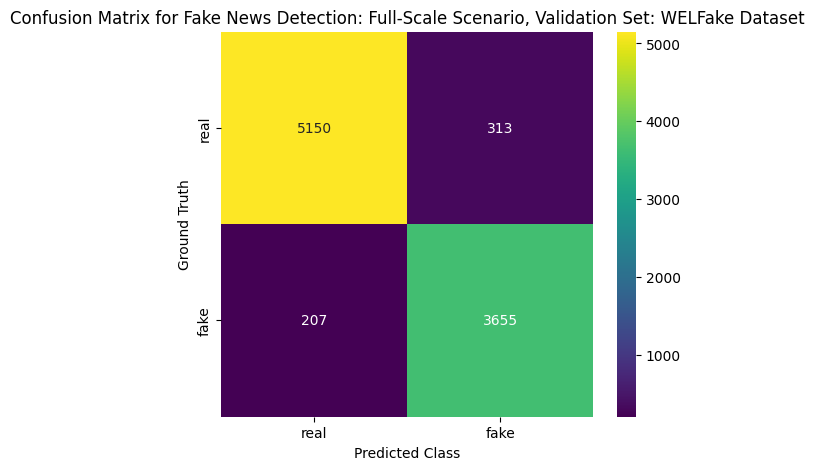

Accuracy: 0.9456
Precision (Macro): 0.9395
Recall (Macro): 0.9466
Macro F1-score: 0.9427

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      6976
           1       0.91      0.95      0.93      4261

    accuracy                           0.95     11237
   macro avg       0.94      0.95      0.94     11237
weighted avg       0.95      0.95      0.95     11237



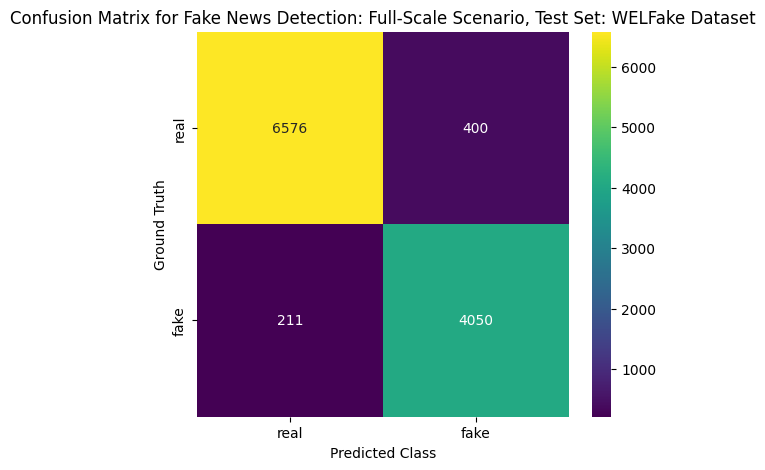

In [9]:
# Transforms the train, val and test texts to TF-IDF matrices
tfidf_wf_train, tfidf_wf_val, tfidf_wf_test = convertToTfidfVectors(X_train_wf, X_val_wf, X_test_wf)

# Trains a Passive Aggressive Classifier model using the TF-IDF vectorized training news texts
pac_model_wf = trainPAModel(tfidf_wf_train, y_train_wf)

# Evaluates the trained classifier on the WELFake validation set
val_dict_wf = evaluatePACModel(
    pac_model_wf,
    tfidf_wf_val, y_val_wf, 
    "Full-Scale Scenario, Validation Set: WELFake Dataset"
)

# Evaluates the trained classifier on the WELFake test set
test_dict_wf = evaluatePACModel(
    pac_model_wf,
    tfidf_wf_test, y_test_wf, 
    "Full-Scale Scenario, Test Set: WELFake Dataset"
)

In [13]:
# Trains a TF-IDF and Passive-Aggressive Classifier Pipeline on this dataset for creating the LIME-explainer Streamlit web application

def trainBasicPipeline(X_train, y_train):
    """
        Trains a basic TF-IDF, Passive-Aggressive Classifier and CalibratedClassifierCV pipeline for outputting 
        prediction probabilities to work with the LIME algorithm.

        Input Parameters:
            X_train (list or array-like): an array of training news texts
            y_train (list or array-like): an array of corresponding target labels (0 = real news, 1 = fake news)

        Output:
            pipeline: the trained scikit-learn pipelne
    """

    # Initializes the PAC or base classifier
    pac = PassiveAggressiveClassifier(max_iter=50)
    
    # Wraps the base mdoel in CalibratedClassifierCV to output the probabilities for LIME Text Explainer explain_instance function
    calibrated_model = CalibratedClassifierCV(pac, method="sigmoid", cv=5)
    
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", max_df=0.7)),
        ("classifier", calibrated_model)
    ])
    
    pipeline.fit(X_train, y_train)
    return pipeline

# Trains the pipeline on the WELFake training data
pipeline = trainBasicPipeline(X_train_wf, y_train_wf)

# Saves the pipeline
joblib.dump(pipeline, "my_model2.joblib")

['my_model2.joblib']

## Fakeddit Dataset

Accuracy: 0.8164
Precision (Macro): 0.8141
Recall (Macro): 0.8129
Macro F1-score: 0.8135

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.84      0.84     39299
           1       0.80      0.78      0.79     31033

    accuracy                           0.82     70332
   macro avg       0.81      0.81      0.81     70332
weighted avg       0.82      0.82      0.82     70332



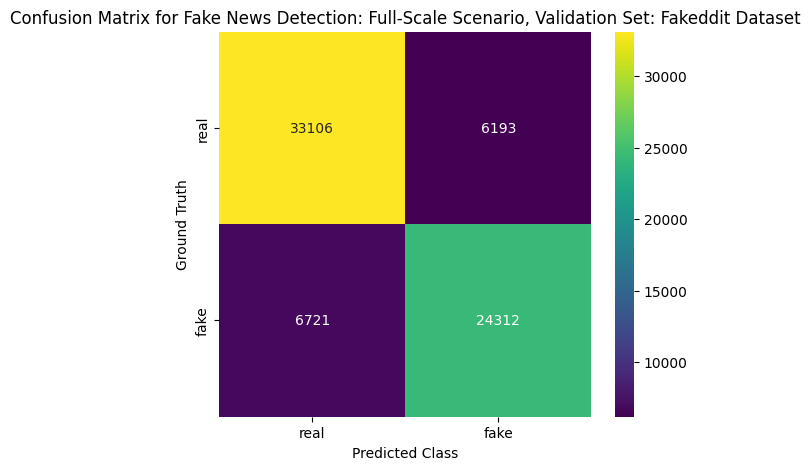

Accuracy: 0.8157
Precision (Macro): 0.8131
Recall (Macro): 0.8122
Macro F1-score: 0.8126

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.84      0.84     39910
           1       0.79      0.78      0.79     31185

    accuracy                           0.82     71095
   macro avg       0.81      0.81      0.81     71095
weighted avg       0.82      0.82      0.82     71095



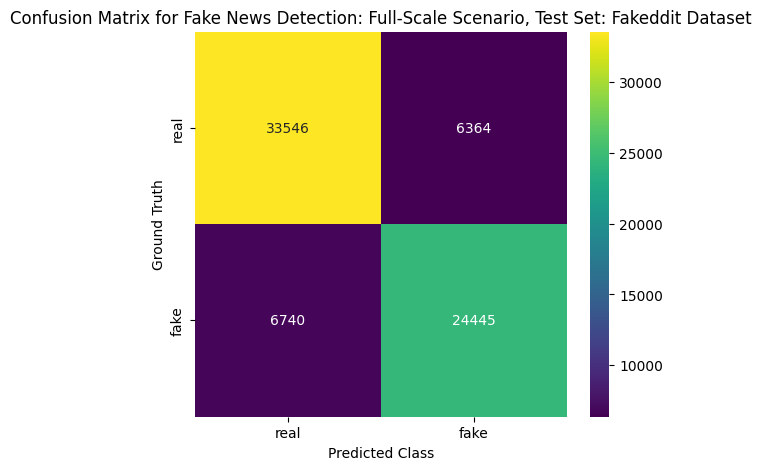

In [12]:
# Transforms the Fakeddit train, val and test texts to TF-IDF matrices
tfidf_fe_train, tfidf_fe_val, tfidf_fe_test = convertToTfidfVectors(X_train_fe, X_val_fe, X_test_fe)

# Trains the Passive Aggressive Classifier model using the Fakeddit TF-IDF vectorized training news texts
pac_model_fe = trainPAModel(tfidf_fe_train, y_train_fe)

# Evaluates the trained classifier on the Fakeddit validation set
val_dict_fe = evaluatePACModel(pac_model_fe, tfidf_fe_val, y_val_fe, "Full-Scale Scenario, Validation Set: Fakeddit Dataset")

# Evaluates the trained classifier on the Fakeddit test set
test_dict_fe = evaluatePACModel(pac_model_fe, tfidf_fe_test, y_test_fe, "Full-Scale Scenario, Test Set: Fakeddit Dataset")

## Constraint Dataset

Accuracy: 0.9384
Precision (Macro): 0.9389
Recall (Macro): 0.9378
Macro F1-score: 0.9382

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1116
           1       0.95      0.92      0.93      1012

    accuracy                           0.94      2128
   macro avg       0.94      0.94      0.94      2128
weighted avg       0.94      0.94      0.94      2128



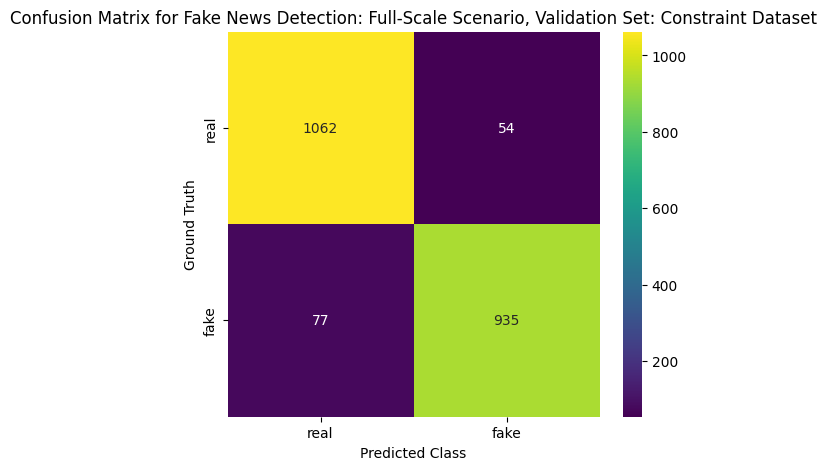

Accuracy: 0.9416
Precision (Macro): 0.9419
Recall (Macro): 0.9410
Macro F1-score: 0.9414

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1115
           1       0.95      0.93      0.94      1007

    accuracy                           0.94      2122
   macro avg       0.94      0.94      0.94      2122
weighted avg       0.94      0.94      0.94      2122



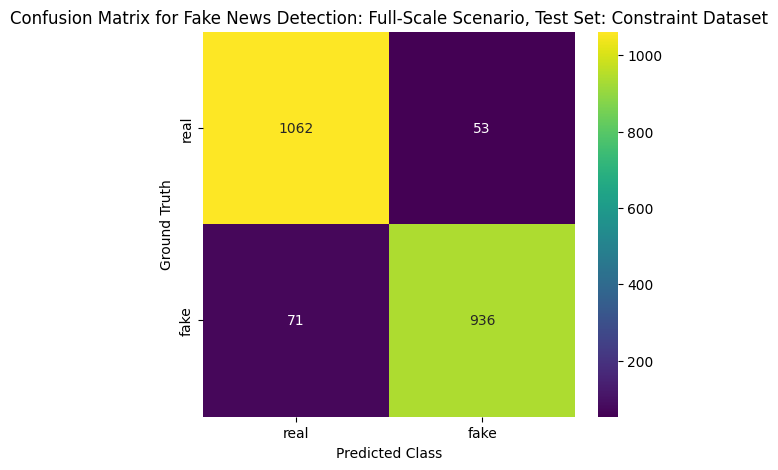

In [13]:
# Transforms the Constraint train, val, and test texts to TF-IDF matrices
tfidf_ct_train, tfidf_ct_val, tfidf_ct_test = convertToTfidfVectors(X_train_ct, X_val_ct, X_test_ct)

# Trains a Passive Aggressive Classifier model using the Constraint TF-IDF vectorized training news texts
pac_model_ct = trainPAModel(tfidf_ct_train, y_train_ct)

# Evaluates the trained classifier on the Constraint validation set
val_dict_ct = evaluatePACModel(pac_model_ct, tfidf_ct_val, y_val_ct, "Full-Scale Scenario, Validation Set: Constraint Dataset")

# Evaluates the trained classifier on the Constraint test set
test_dict_ct = evaluatePACModel(pac_model_ct, tfidf_ct_test, y_test_ct, "Full-Scale Scenario, Test Set: Constraint Dataset")

## PolitiFact Dataset

Accuracy: 0.8942
Precision (Macro): 0.8922
Recall (Macro): 0.8989
Macro F1-score: 0.8934

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.86      0.90        59
           1       0.84      0.93      0.88        45

    accuracy                           0.89       104
   macro avg       0.89      0.90      0.89       104
weighted avg       0.90      0.89      0.89       104



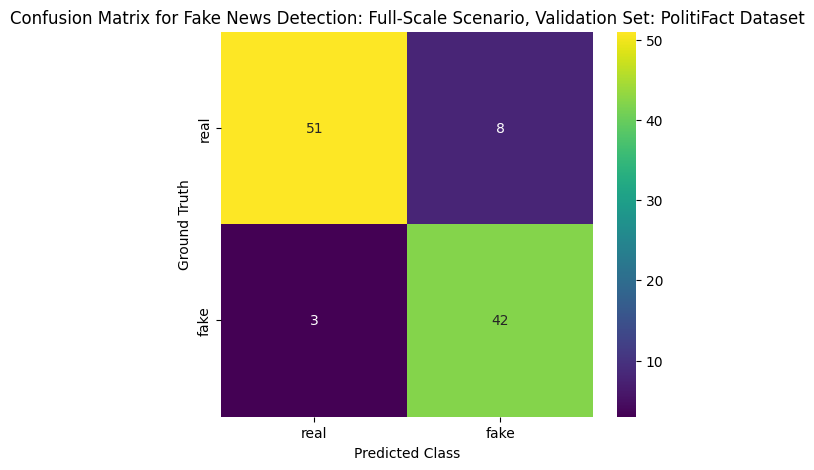

Accuracy: 0.8889
Precision (Macro): 0.8898
Recall (Macro): 0.8898
Macro F1-score: 0.8889

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.92      0.89        61
           1       0.92      0.86      0.89        65

    accuracy                           0.89       126
   macro avg       0.89      0.89      0.89       126
weighted avg       0.89      0.89      0.89       126



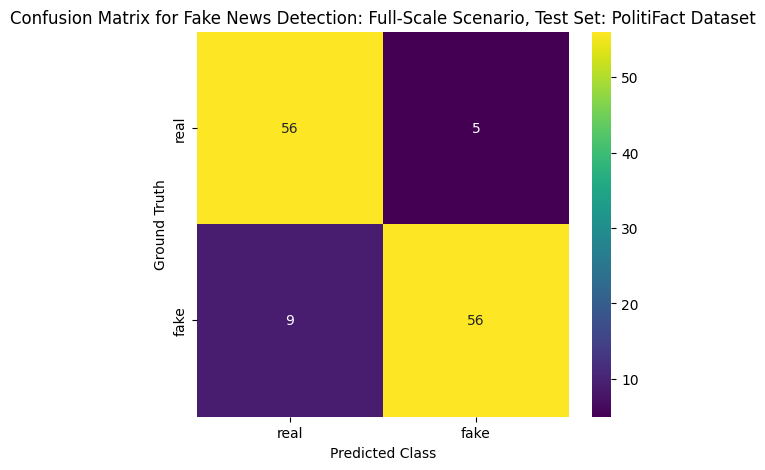

In [14]:
# Transforms the PolitiFact train, val, and test texts to TF-IDF matrices
tfidf_pf_train, tfidf_pf_val, tfidf_pf_test = convertToTfidfVectors(X_train_pf, X_val_pf, X_test_pf)

# Trains a Passive Aggressive Classifier model using the PolitiFact TF-IDF vectorized training news texts
pac_model_pf = trainPAModel(tfidf_pf_train, y_train_pf)

# Evaluates the trained classifier on the PolitiFact validation set
val_dict_pf = evaluatePACModel(pac_model_pf, tfidf_pf_val, y_val_pf, "Full-Scale Scenario, Validation Set: PolitiFact Dataset")

# Evaluates the trained classifier on the PolitiFact test set
test_dict_pf = evaluatePACModel(pac_model_pf, tfidf_pf_test, y_test_pf, "Full-Scale Scenario, Test Set: PolitiFact Dataset")

## GossipCop Dataset

Accuracy: 0.8304
Precision (Macro): 0.7656
Recall (Macro): 0.7387
Macro F1-score: 0.7503

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2018
           1       0.66      0.57      0.61       612

    accuracy                           0.83      2630
   macro avg       0.77      0.74      0.75      2630
weighted avg       0.82      0.83      0.83      2630



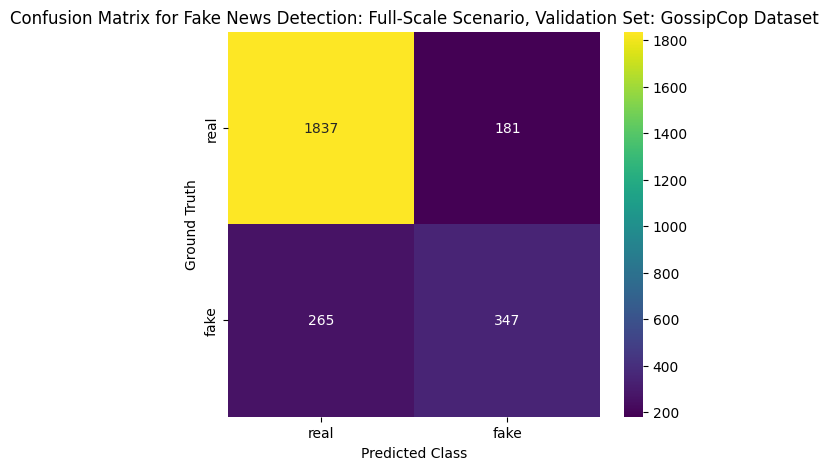

Accuracy: 0.8218
Precision (Macro): 0.7551
Recall (Macro): 0.7278
Macro F1-score: 0.7394

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2444
           1       0.64      0.55      0.59       755

    accuracy                           0.82      3199
   macro avg       0.76      0.73      0.74      3199
weighted avg       0.81      0.82      0.82      3199



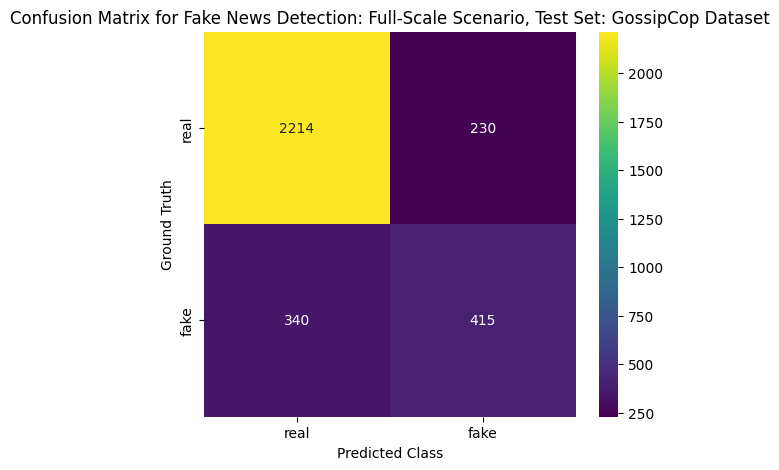

In [15]:
# Transforms the GossipCop train, val, and test texts to TF-IDF matrices
tfidf_gc_train, tfidf_gc_val, tfidf_gc_test = convertToTfidfVectors(X_train_gc, X_val_gc, X_test_gc)

# Trains a Passive Aggressive Classifier model using the GossipCop TF-IDF vectorized training news texts
pac_model_gc = trainPAModel(tfidf_gc_train, y_train_gc)

# Evaluates the trained classifier on the GossipCop validation set
val_dict_gc = evaluatePACModel(pac_model_gc, tfidf_gc_val, y_val_gc, "Full-Scale Scenario, Validation Set: GossipCop Dataset")

# Evaluates the trained classifier on the GossipCop test set
test_dict_gc = evaluatePACModel(pac_model_gc, tfidf_gc_test, y_test_gc, "Full-Scale Scenario, Test Set: GossipCop Dataset")

## 4-Text-Dataset Combined Data

Accuracy: 0.8878
Precision (Macro): 0.8815
Recall (Macro): 0.8831
Macro F1-score: 0.8823

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      8656
           1       0.85      0.86      0.86      5531

    accuracy                           0.89     14187
   macro avg       0.88      0.88      0.88     14187
weighted avg       0.89      0.89      0.89     14187



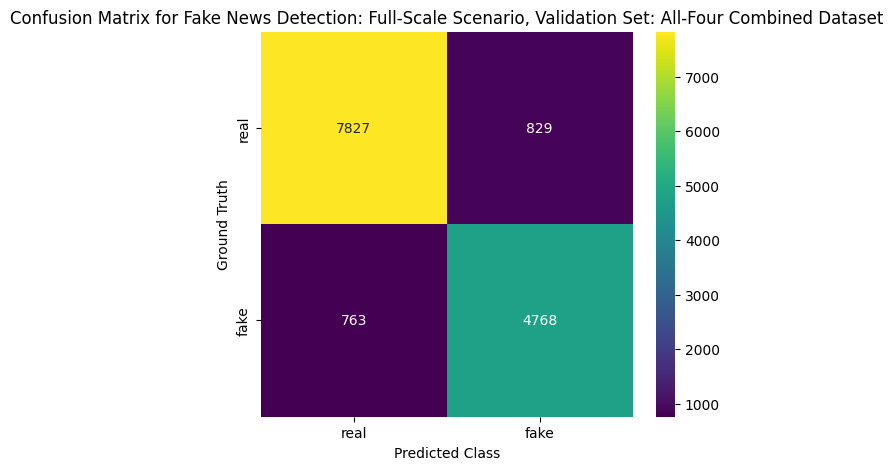

Accuracy: 0.8880
Precision (Macro): 0.8777
Recall (Macro): 0.8824
Macro F1-score: 0.8799

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     10596
           1       0.84      0.86      0.85      6087

    accuracy                           0.89     16683
   macro avg       0.88      0.88      0.88     16683
weighted avg       0.89      0.89      0.89     16683



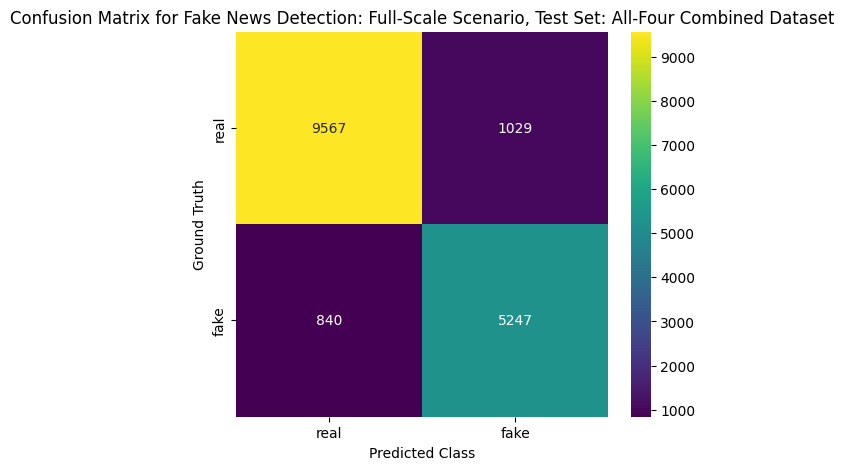

In [16]:
# Transforms the All-Four text-only combined data train, val, and test texts to TF-IDF matrices
tfidf_all_train, tfidf_all_val, tfidf_all_test = convertToTfidfVectors(X_train_all, X_val_all, X_test_all)

# Trains a Passive Aggressive Classifier model using the All-Four combined data TF-IDF vectorized training news texts
pac_model_all = trainPAModel(tfidf_all_train, y_train_all)

# Evaluates the trained classifier on the All-Four Combined validation set
val_dict_all = evaluatePACModel(pac_model_all, tfidf_all_val, y_val_all, "Full-Scale Scenario, Validation Set: All-Four Combined Dataset")

# Evaluates the trained classifier on the All-Four Combined test set
test_dict_all = evaluatePACModel(pac_model_all, tfidf_all_test, y_test_all, "Full-Scale Scenario, Test Set: All-Four Combined Dataset")

## Training and Evaluating in the Five-Shot (3 Source Mixed Dataset, 5 Random Samples from Target Dataset used for Validation) Scenario

### Target Dataset: WELFake

Accuracy: 0.6225
Precision (Macro): 0.6062
Recall (Macro): 0.5990
Macro F1-score: 0.5995

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.74      0.70      5463
           1       0.55      0.46      0.50      3862

    accuracy                           0.62      9325
   macro avg       0.61      0.60      0.60      9325
weighted avg       0.62      0.62      0.62      9325



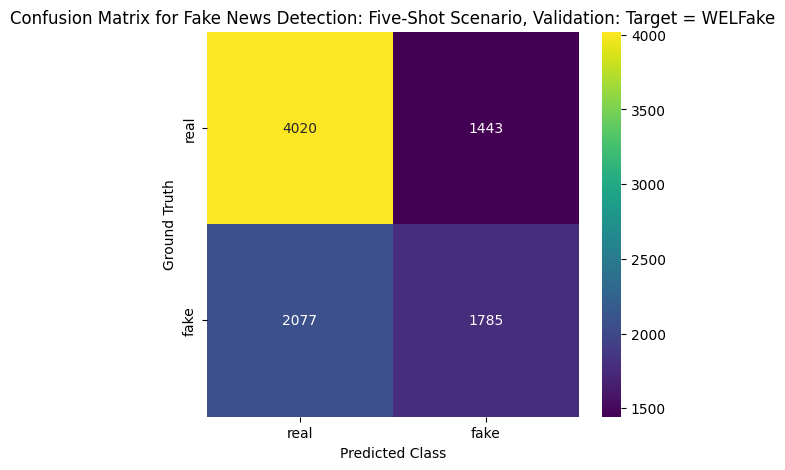

Accuracy: 0.6380
Precision (Macro): 0.6100
Recall (Macro): 0.6040
Macro F1-score: 0.6056

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.74      0.72      6976
           1       0.53      0.46      0.49      4261

    accuracy                           0.64     11237
   macro avg       0.61      0.60      0.61     11237
weighted avg       0.63      0.64      0.63     11237



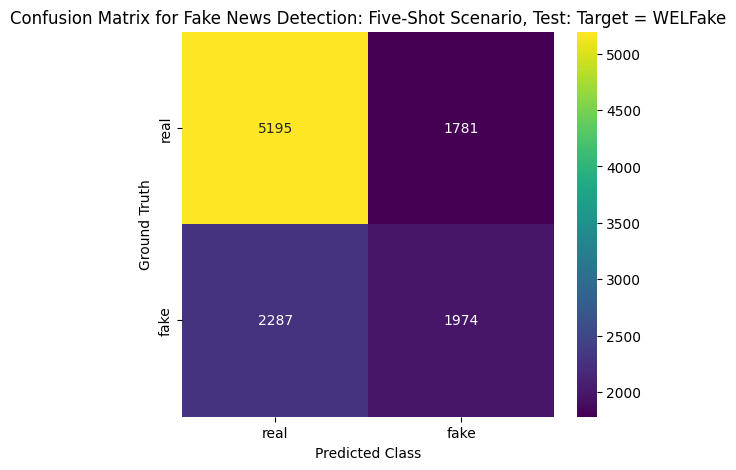

In [17]:
# Uses the WELFake-left out five-shot set for training and the WELFake validation and test sets for evaluation
# Converts all these to TF-IDF matrices, using leave-one-out training vocab to transform the target val and test sets
five_shot_tfidf_wf_train, five_shot_tfidf_wf_val, five_shot_tfidf_wf_test = convertToTfidfVectors(
    X_train_five_shot_wf_df,
    X_val_wf,
    X_test_wf
) 

# Trains the Passive Aggressive Classifier model with the TF-IDF vectorized texts
pac_model_five_shot_wf = trainPAModel(five_shot_tfidf_wf_train, y_train_five_shot_wf_df)

# Evaluates on the WELFake validation set
five_shot_val_dict_wf = evaluatePACModel(
    pac_model_five_shot_wf,
    five_shot_tfidf_wf_val,
    y_val_wf,
    "Five-Shot Scenario, Validation: Target = WELFake")

# Evaluates on the WELFake test set
five_shot_test_dict_wf = evaluatePACModel(
    pac_model_five_shot_wf,
    five_shot_tfidf_wf_test,
    y_test_wf,
    "Five-Shot Scenario, Test: Target = WELFake")

### Target Dataset: Constraint

Accuracy: 0.5108
Precision (Macro): 0.5334
Recall (Macro): 0.5239
Macro F1-score: 0.4801

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.26      0.35      1116
           1       0.49      0.79      0.61      1012

    accuracy                           0.51      2128
   macro avg       0.53      0.52      0.48      2128
weighted avg       0.54      0.51      0.47      2128



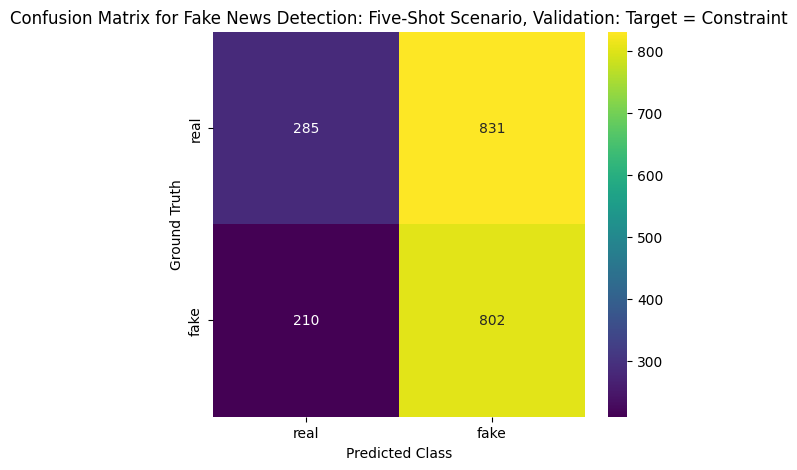

Accuracy: 0.5094
Precision (Macro): 0.5296
Recall (Macro): 0.5222
Macro F1-score: 0.4833

Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.27      0.37      1115
           1       0.49      0.77      0.60      1007

    accuracy                           0.51      2122
   macro avg       0.53      0.52      0.48      2122
weighted avg       0.53      0.51      0.48      2122



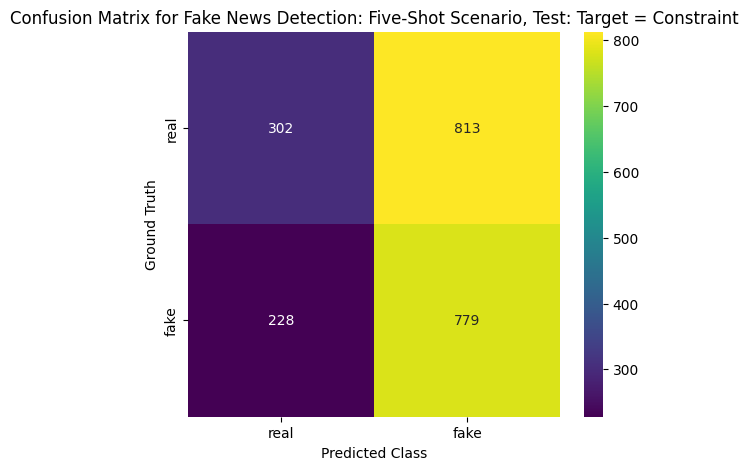

In [18]:
# Uses the Constraint-left out five-shot set for training and the Constraint validation and test sets for evaluation
# Converts all these to TF-IDF matrices, using leave-one-out training vocab to transform the target val and test sets
five_shot_tfidf_ct_train, five_shot_tfidf_ct_val, five_shot_tfidf_ct_test = convertToTfidfVectors(
    X_train_five_shot_ct_df,
    X_val_ct,
    X_test_ct
) 

# Trains the Passive Aggressive Classifier model with the TF-IDF vectorized texts
pac_model_five_shot_ct = trainPAModel(five_shot_tfidf_ct_train, y_train_five_shot_ct_df)

# Evaluates on the Constraint validation set
five_shot_val_dict_ct = evaluatePACModel(
    pac_model_five_shot_ct,
    five_shot_tfidf_ct_val,
    y_val_ct,
    "Five-Shot Scenario, Validation: Target = Constraint")

# Evaluates on the Constraint test set
five_shot_test_dict_ct = evaluatePACModel(
    pac_model_five_shot_ct,
    five_shot_tfidf_ct_test,
    y_test_ct,
    "Five-Shot Scenario, Test: Target = Constraint")

### Target Dataset: PolitiFact

Accuracy: 0.6346
Precision (Macro): 0.6334
Recall (Macro): 0.6358
Macro F1-score: 0.6324

Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.63      0.66        59
           1       0.57      0.64      0.60        45

    accuracy                           0.63       104
   macro avg       0.63      0.64      0.63       104
weighted avg       0.64      0.63      0.64       104



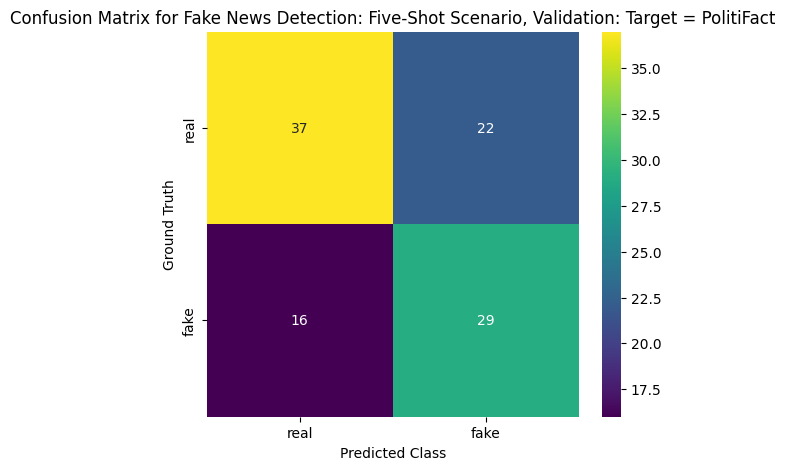

Accuracy: 0.5952
Precision (Macro): 0.5947
Recall (Macro): 0.5946
Macro F1-score: 0.5946

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.57      0.58        61
           1       0.61      0.62      0.61        65

    accuracy                           0.60       126
   macro avg       0.59      0.59      0.59       126
weighted avg       0.60      0.60      0.60       126



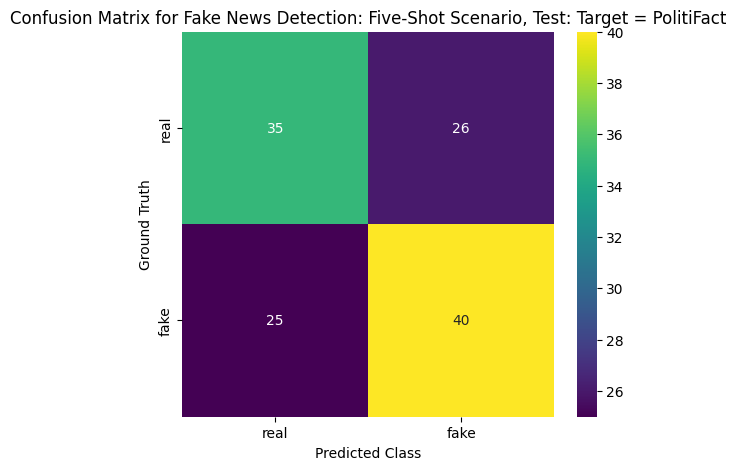

In [19]:
# Uses the PolitiFact-left out five-shot set for training and the PolitiFact validation and test sets for evaluation
# Converts all these to TF-IDF matrices, using leave-one-out training vocab to transform the target val and test sets
five_shot_tfidf_pf_train, five_shot_tfidf_pf_val, five_shot_tfidf_pf_test = convertToTfidfVectors(
    X_train_five_shot_pf_df,
    X_val_pf,
    X_test_pf
) 

# Trains the Passive Aggressive Classifier model with the TF-IDF vectorized texts
pac_model_five_shot_pf = trainPAModel(five_shot_tfidf_pf_train, y_train_five_shot_pf_df)

# Evaluates on the PolitiFact validation set
five_shot_val_dict_pf = evaluatePACModel(
    pac_model_five_shot_pf,
    five_shot_tfidf_pf_val,
    y_val_pf,
    "Five-Shot Scenario, Validation: Target = PolitiFact")

# Evaluates on the PolitiFact test set
five_shot_test_dict_pf = evaluatePACModel(
    pac_model_five_shot_pf,
    five_shot_tfidf_pf_test,
    y_test_pf,
    "Five-Shot Scenario, Test: Target = PolitiFact")

### Target Dataset: GossipCop

Accuracy: 0.4312
Precision (Macro): 0.5524
Recall (Macro): 0.5605
Macro F1-score: 0.4293

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.32      0.46      2018
           1       0.26      0.80      0.40       612

    accuracy                           0.43      2630
   macro avg       0.55      0.56      0.43      2630
weighted avg       0.71      0.43      0.45      2630



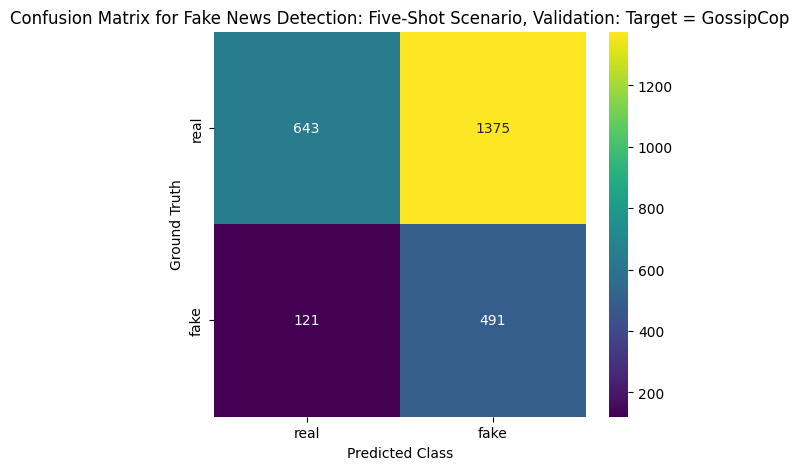

Accuracy: 0.4483
Precision (Macro): 0.5740
Recall (Macro): 0.5840
Macro F1-score: 0.4468

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.33      0.48      2444
           1       0.28      0.84      0.42       755

    accuracy                           0.45      3199
   macro avg       0.57      0.58      0.45      3199
weighted avg       0.73      0.45      0.46      3199



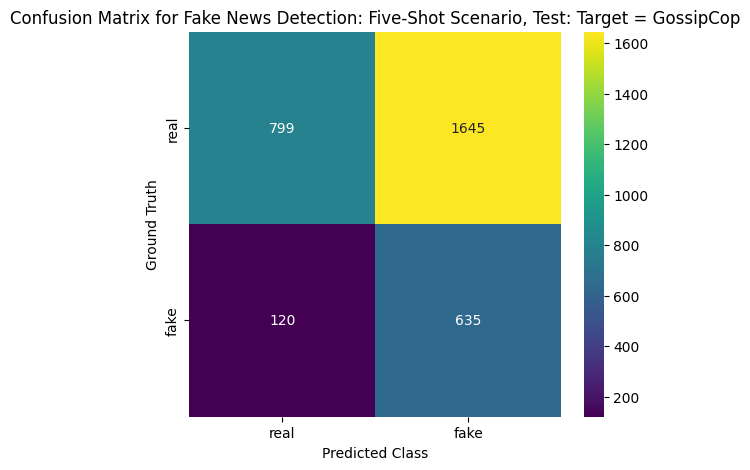

In [20]:
# Uses the GossipCop-left out five-shot set for training and the GossipCop validation and test sets for evaluation
# Converts all these to TF-IDF matrices, using leave-one-out training vocab to transform the target val and test sets
five_shot_tfidf_gc_train, five_shot_tfidf_gc_val, five_shot_tfidf_gc_test = convertToTfidfVectors(
    X_train_five_shot_gc_df,
    X_val_gc,
    X_test_gc
) 

# Trains the Passive Aggressive Classifier model with the TF-IDF vectorized texts
pac_model_five_shot_gc = trainPAModel(five_shot_tfidf_gc_train, y_train_five_shot_gc_df)

# Evaluates on the GossipCop validation set
five_shot_val_dict_gc = evaluatePACModel(
    pac_model_five_shot_gc,
    five_shot_tfidf_gc_val,
    y_val_gc,
    "Five-Shot Scenario, Validation: Target = GossipCop")

# Evaluates on the GossipCop test set
five_shot_test_dict_gc = evaluatePACModel(
    pac_model_five_shot_gc,
    five_shot_tfidf_gc_test,
    y_test_gc,
    "Five-Shot Scenario, Test: Target = GossipCop")

## Training and Evaluating in the Zero-Shot (4 Source Mixed Dataset, 0 Samples from Target Dataset used for Validation) Scenario

### Target Dataset: WELFake

Accuracy: 0.6188
Precision (Macro): 0.6020
Recall (Macro): 0.5952
Macro F1-score: 0.5956

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.73      0.69      5463
           1       0.55      0.46      0.50      3862

    accuracy                           0.62      9325
   macro avg       0.60      0.60      0.60      9325
weighted avg       0.61      0.62      0.61      9325



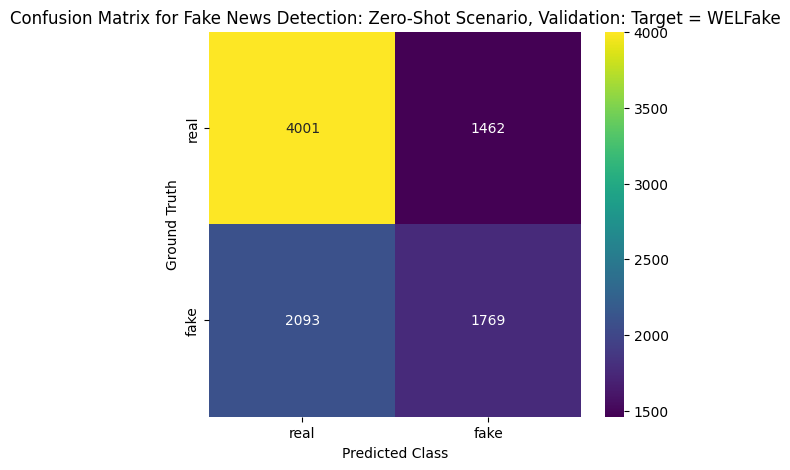

Accuracy: 0.6390
Precision (Macro): 0.6112
Recall (Macro): 0.6050
Macro F1-score: 0.6067

Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.75      0.72      6976
           1       0.53      0.46      0.49      4261

    accuracy                           0.64     11237
   macro avg       0.61      0.61      0.61     11237
weighted avg       0.63      0.64      0.63     11237



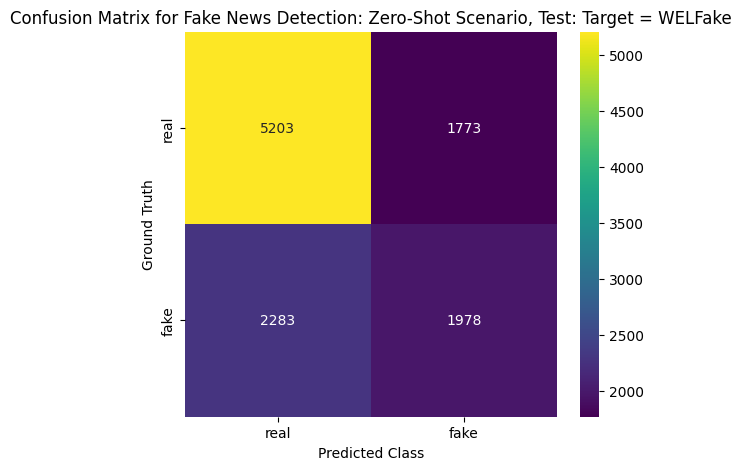

In [21]:
# Uses the WELFake-left out zero-shot set for training and the WELFake validation and test sets for evaluation
# Converts all these to TF-IDF matrices, using leave-one-out training vocab to transform the target val and test sets
zero_shot_tfidf_wf_train, zero_shot_tfidf_wf_val, zero_shot_tfidf_wf_test = convertToTfidfVectors(
    X_train_zero_shot_wf_df,
    X_val_wf,
    X_test_wf
) 

# Trains the Passive Aggressive Classifier model with the TF-IDF vectorized texts
pac_model_zero_shot_wf = trainPAModel(zero_shot_tfidf_wf_train, y_train_zero_shot_wf_df)

# Evaluates on the WELFake validation set
zero_shot_val_dict_wf = evaluatePACModel(
    pac_model_zero_shot_wf,
    zero_shot_tfidf_wf_val,
    y_val_wf,
    "Zero-Shot Scenario, Validation: Target = WELFake")

# Evaluates on the WELFake test set
zero_shot_test_dict_wf = evaluatePACModel(
    pac_model_zero_shot_wf,
    zero_shot_tfidf_wf_test,
    y_test_wf,
    "Zero-Shot Scenario, Test: Target = WELFake")

### Target Dataset: Constraint

Accuracy: 0.4821
Precision (Macro): 0.4924
Recall (Macro): 0.4942
Macro F1-score: 0.4551

Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.25      0.33      1116
           1       0.47      0.74      0.58      1012

    accuracy                           0.48      2128
   macro avg       0.49      0.49      0.46      2128
weighted avg       0.49      0.48      0.45      2128



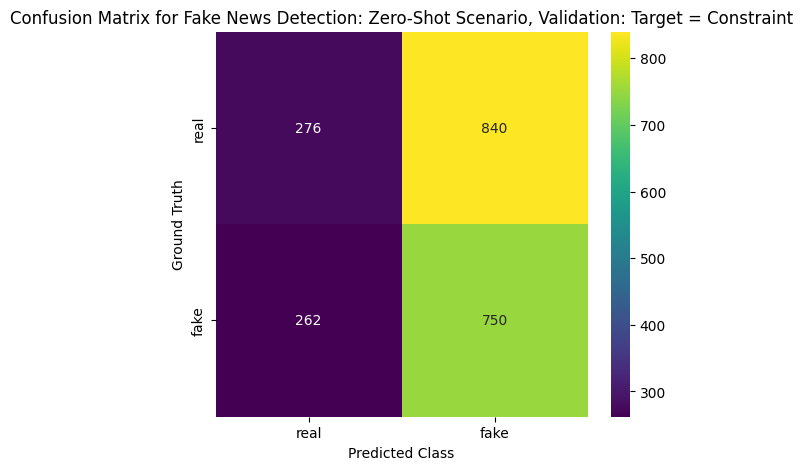

Accuracy: 0.4807
Precision (Macro): 0.4904
Recall (Macro): 0.4924
Macro F1-score: 0.4578

Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.26      0.35      1115
           1       0.47      0.72      0.57      1007

    accuracy                           0.48      2122
   macro avg       0.49      0.49      0.46      2122
weighted avg       0.49      0.48      0.45      2122



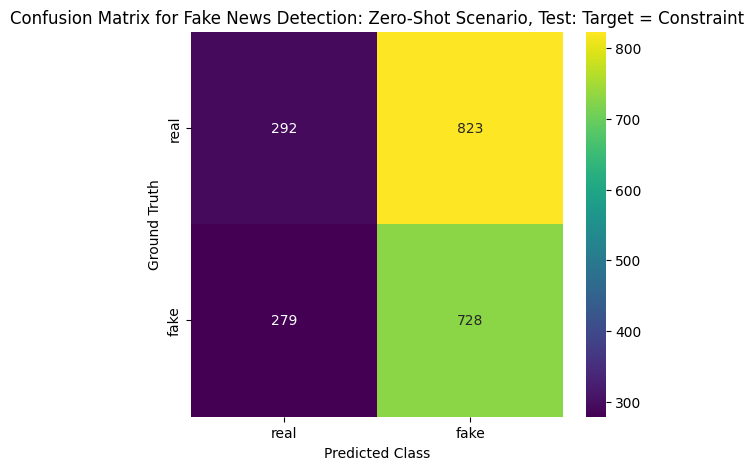

In [22]:
# Uses the Constraint-left out zero-shot set for training and the Constraint validation and test sets for evaluation
# Converts all these to TF-IDF matrices, using leave-one-out training vocab to transform the target val and test sets
zero_shot_tfidf_ct_train, zero_shot_tfidf_ct_val, zero_shot_tfidf_ct_test = convertToTfidfVectors(
    X_train_zero_shot_ct_df,
    X_val_ct,
    X_test_ct
) 

# Trains the Passive Aggressive Classifier model with the TF-IDF vectorized texts
pac_model_zero_shot_ct = trainPAModel(zero_shot_tfidf_ct_train, y_train_zero_shot_ct_df)

# Evaluates on the Constraint validation set
zero_shot_val_dict_ct = evaluatePACModel(
    pac_model_zero_shot_ct,
    zero_shot_tfidf_ct_val,
    y_val_ct,
    "Zero-Shot Scenario, Validation: Target = Constraint")

# Evaluates on the Constraint test set
zero_shot_test_dict_ct = evaluatePACModel(
    pac_model_zero_shot_ct,
    zero_shot_tfidf_ct_test,
    y_test_ct,
    "Zero-Shot Scenario, Test: Target = Constraint")

### Target Dataset: PolitiFact

Accuracy: 0.6442
Precision (Macro): 0.6419
Recall (Macro): 0.6443
Macro F1-score: 0.6415

Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        59
           1       0.58      0.64      0.61        45

    accuracy                           0.64       104
   macro avg       0.64      0.64      0.64       104
weighted avg       0.65      0.64      0.65       104



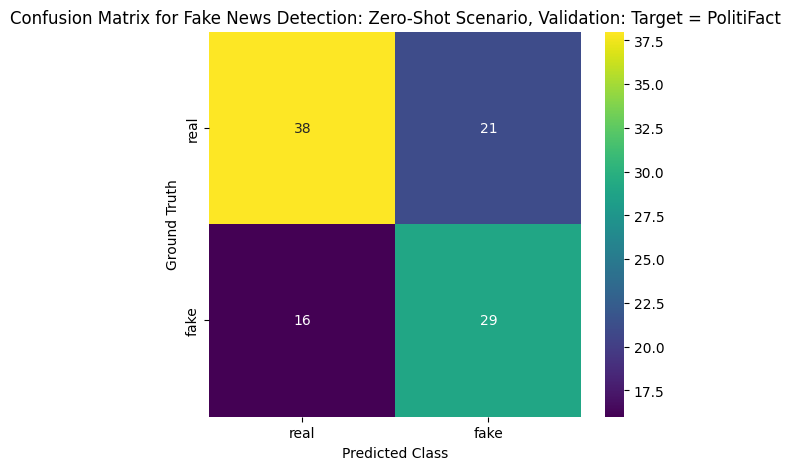

Accuracy: 0.6032
Precision (Macro): 0.6026
Recall (Macro): 0.6023
Macro F1-score: 0.6023

Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.57      0.58        61
           1       0.61      0.63      0.62        65

    accuracy                           0.60       126
   macro avg       0.60      0.60      0.60       126
weighted avg       0.60      0.60      0.60       126



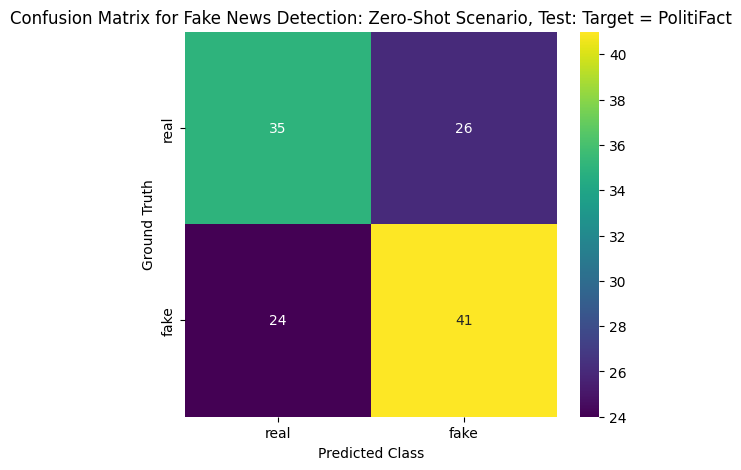

In [23]:
# Uses the PolitiFact-left out zero-shot set for training and the PolitiFact validation and test sets for evaluation
# Converts all these to TF-IDF matrices, using leave-one-out training vocab to transform the target val and test sets
zero_shot_tfidf_pf_train, zero_shot_tfidf_pf_val, zero_shot_tfidf_pf_test = convertToTfidfVectors(
    X_train_zero_shot_pf_df,
    X_val_pf,
    X_test_pf
) 

# Trains the Passive Aggressive Classifier model with the TF-IDF vectorized texts
pac_model_zero_shot_pf = trainPAModel(zero_shot_tfidf_pf_train, y_train_zero_shot_pf_df)

# Evaluate on the PolitiFact validation set
zero_shot_val_dict_pf = evaluatePACModel(
    pac_model_zero_shot_pf,
    zero_shot_tfidf_pf_val,
    y_val_pf,
    "Zero-Shot Scenario, Validation: Target = PolitiFact")

# Evaluate on the PolitiFact test set
zero_shot_test_dict_pf = evaluatePACModel(
    pac_model_zero_shot_pf,
    zero_shot_tfidf_pf_test,
    y_test_pf,
    "Zero-Shot Scenario, Test: Target = PolitiFact")

### Target Dataset: GossipCop

Accuracy: 0.4316
Precision (Macro): 0.5531
Recall (Macro): 0.5613
Macro F1-score: 0.4297

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.32      0.46      2018
           1       0.26      0.80      0.40       612

    accuracy                           0.43      2630
   macro avg       0.55      0.56      0.43      2630
weighted avg       0.71      0.43      0.45      2630



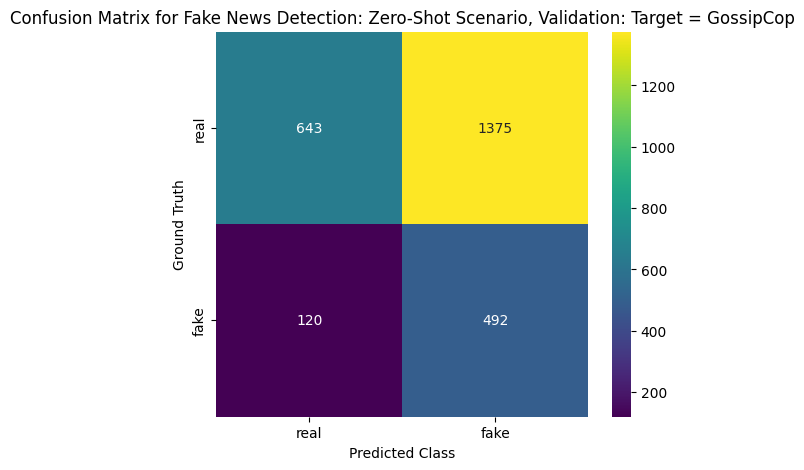

Accuracy: 0.4420
Precision (Macro): 0.5673
Recall (Macro): 0.5762
Macro F1-score: 0.4406

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.32      0.47      2444
           1       0.27      0.83      0.41       755

    accuracy                           0.44      3199
   macro avg       0.57      0.58      0.44      3199
weighted avg       0.72      0.44      0.46      3199



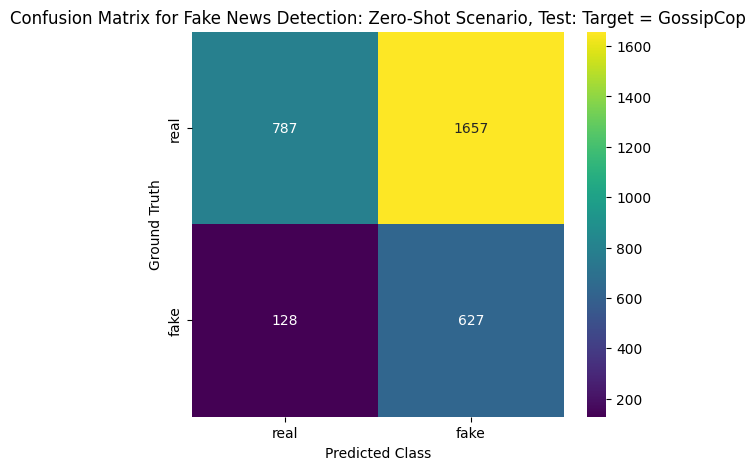

In [24]:
# Uses the GossipCop-left out zero-shot set for training and the GossipCop validation and test sets for evaluation
# Converts all these to TF-IDF matrices, using leave-one-out training vocab to transform the target val and test sets
zero_shot_tfidf_gc_train, zero_shot_tfidf_gc_val, zero_shot_tfidf_gc_test = convertToTfidfVectors(
    X_train_zero_shot_gc_df,
    X_val_gc,
    X_test_gc
) 

# Trains the Passive Aggressive Classifier model with the TF-IDF vectorized texts
pac_model_zero_shot_gc = trainPAModel(zero_shot_tfidf_gc_train, y_train_zero_shot_gc_df)

# Evaluates on the GossipCop validation set
zero_shot_val_dict_gc = evaluatePACModel(
    pac_model_zero_shot_gc,
    zero_shot_tfidf_gc_val,
    y_val_gc,
    "Zero-Shot Scenario, Validation: Target = GossipCop")

# Evaluates on the GossipCop test set
zero_shot_test_dict_gc = evaluatePACModel(
    pac_model_zero_shot_gc,
    zero_shot_tfidf_gc_test,
    y_test_gc,
    "Zero-Shot Scenario, Test: Target = GossipCop")

## Evaluation Results for Baseline Classifier with TF-IDF and Passive-Aggressive Classifier following Basic DataFlair Approach


### Results for Full-Scale Evaluation Scenario

| Dataset         | Split   | Accuracy | Macro Precision | Macro Recall | Macro F1-score |
|-----------------|-------|----------|-------------------|----------------|----------------|
| WELFake         | Val   | 0.9450   | 0.9420            | 0.9453         | 0.9435         |
| WELFake         | Test  | 0.9455   | 0.9394            | 0.9465         | 0.9426         |
| Fakeddit        | Val   | 0.8164   | 0.8141            | 0.8129         | 0.8135         |
| Fakeddit        | Test  | 0.8157   | 0.8131            | 0.8122         | 0.8126         |
| Constraint      | Val   | 0.9384   | 0.9389            | 0.9378         | 0.9382         |
| Constraint      | Test  | 0.9416   | 0.9419            | 0.9410         | 0.9414         |
| PolitiFact      | Val   | 0.8942   | 0.8922            | 0.8989         | 0.8934         |
| PolitiFact      | Test  | 0.8889   | 0.8898            | 0.8898         | 0.8889         |
| GossipCop       | Val   | 0.8304   | 0.7656            | 0.7387         | 0.7503         |
| GossipCop       | Test  | 0.8218   | 0.7551            | 0.7278         | 0.7394         |
| All-Four        | Val   | 0.8878   | 0.8815            | 0.8831         | 0.8823         |
| All-Four        | Test  | 0.8880   | 0.8777            | 0.8824         | 0.8799         |


### Results for Five-Shot Evaluation Scenario

| Dataset                     | Split   | Accuracy | Macro Precision | Macro Recall | Macro F1-score |
|-----------------------------|-------|----------|-------------------|----------------|----------------|
| Five-Shot WELFake target           | Val   | 0.6225   | 0.6062            | 0.5990         | 0.5995         |
| Five-Shot WELFake target          | Test  | 0.6380   | 0.6100            | 0.6040         | 0.6056         |
| Five-Shot Constraint target      | Val   | 0.5108   | 0.5334            | 0.5239         | 0.4801         |
| Five-Shot Constraint target       | Test  | 0.5094   | 0.5296            | 0.5222         | 0.4833         |
| Five-Shot PolitiFact target       | Val   | 0.6346   | 0.6334            | 0.6358         | 0.6324         |
| Five-Shot PolitiFact target        | Test  | 0.5952   | 0.5947            | 0.5946         | 0.5946         |
| Five-Shot GossipCop target         | Val   | 0.4312   | 0.5524            | 0.5605         | 0.4293         |
| Five-Shot GossipCop target         | Test  | 0.4483   | 0.5740            | 0.5840         | 0.4468         |

### Results for Zero-Shot Evaluation Scenario

| Dataset                    | Split   | Accuracy | Macro Precision | Macro Recall | Macro F1-score |
|----------------------------|-------|----------|-------------------|----------------|----------------|
| Zero-Shot WELFake target   | Val   | 0.6188   | 0.6020            | 0.5952         | 0.5956         |
| Zero-Shot WELFake target   | Test  | 0.6390   | 0.6112            | 0.6050         | 0.6067         |
| Zero-Shot Constraint target      | Val   | 0.4821   | 0.4924            | 0.4942         | 0.4551         |
| Zero-Shot Constraint target      | Test  | 0.4807   | 0.4904            | 0.4924         | 0.4578         |
| Zero-Shot PolitiFact target      | Val   | 0.6442   | 0.6419            | 0.6443         | 0.6415         |
| Zero-Shot PolitiFact target      | Test  | 0.6032   | 0.6026            | 0.6023         | 0.6023         |
| Zero-Shot GossipCop target       | Val   | 0.4316   | 0.5531            | 0.5613         | 0.4297         |
| Zero-Shot GossipCop target       | Test  | 0.4420   | 0.5673            | 0.5762         | 0.4406         |